GET THE ORIGINAL DATA.  
GENERATE MATRIX FOR X,  
WITH X FROM **'op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'size_d1', 'size_d2'**  
WITH Y FROM **'anual_cc_return_future'**

In [126]:
isGoogleColab = False

if(isGoogleColab):
    from google.colab import drive
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import math

In [2]:
industry_dict = {'Accommodation and Food Services':'Services',
       'Administrative and Support and Waste Management and Remediation Services':'Services',
       'Agriculture, Forestry, Fishing and Hunting':'Agriculture',
       'Arts, Entertainment, and Recreation':'Services', 
       'Construction':'Construction',
       'Educational Services':'Services', 
       'Finance and Insurance':'Finance',
       'Health Care and Social Assistance':'Services', 
       'Information':'Services',
       'Manufacturing':'Manufacturing', 
       'Mining, Quarrying, and Oil and Gas Extraction':'Mining',
       'Other Services (except Public Administration)':'Services',
       'Professional, Scientific, and Technical Services':'Services',
       'Real Estate and Rental and Leasing':'Finance', 
       'Retail Trade':'Comercial',
       'Transportation and Warehousing':'Services', 
       'Utilities':'Energy', 
       'Wholesale Trade':'Comercial'}

In [3]:
if(isGoogleColab):
    drive.mount("/content/gdrive") 
    %cd "/content/gdrive/MyDrive/Machine Learning/deliver/M1"
df = pd.read_csv('us2022q2a.csv')
df_firm = pd.read_csv('usfirms2022.csv')

In [4]:
bIsAproachNew = False

df_more = df.copy()

#put industry column
firm_list = df['firm'].unique()
firm_list = firm_list.tolist()
firm_list.remove(np.nan)
df_firm_more = df_firm.copy()
df_firm_more['industry'] = df_firm_more['Sector NAICS\nlevel 1']
df_firm_more = df_firm_more.replace({'industry': industry_dict})

firm_industry_dic = {}

if(bIsAproachNew):
  firm_industry_dic_temp = {}

  for count in range(df_firm_more['Ticker'].count()):
    firm_industry_dic_temp[df_firm_more['Ticker'][count]] = df_firm_more['industry'][count]

  #print(firm_industry_dic_temp)
else:
  for firm in firm_list:
    if (len((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist()) > 0):
      firm_industry_dic[firm] = ((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist())[0]
    else:
      firm_industry_dic[firm] = np.nan

for firm in firm_list:
    if(bIsAproachNew):
      if((len(firm) > 0) and (firm in firm_industry_dic_temp)):
        firm_industry_dic[firm] = firm_industry_dic_temp[firm]
      #else:
      #  firm_industry_dic[firm] = np.nan
    else:
      if(len(firm) > 0):
        #firm_industry_dic[firm] = ((df_firm_more[df_firm_more['Ticker'] == firm]['industry']).values.tolist())[0]
        temp_df = df_firm_more[df_firm_more['Ticker'] == firm]
        if(temp_df['industry'].count() > 0):
          firm_industry_dic[firm] = temp_df['industry'].tolist()[0]
      #else:
      #  firm_industry_dic[firm] = np.nan

df_more['industry'] = df_more['firm']
df_more = df_more.replace({'industry': firm_industry_dic})


#put country column
firm_country_dict = {}
for count in range(df_firm['Ticker'].count()):
    firm = df_firm['Ticker'][count]
    country = df_firm['Country\nof Origin'][count]
    firm_country_dict[firm] = country

df_more['country'] = df_more['firm']
df_more = df_more.replace({'country':firm_country_dict})
#drop the line which all column is empty
df_more = df_more.dropna(how='all')
#df_more

In [5]:
df_more['firm_index'] = df_more['firm']
df_more['q_index'] = df_more['q']
df_more.set_index(['firm_index','q_index'], inplace=True)
#add Date
df_more['date'] = pd.to_datetime(df_more['q'])

#Calculate bookvalue
df_more['bookvalue'] = df_more['totalassets'] - df_more['totalliabilities']

#Calculate Market Value
df_more['marketvalue'] = df_more['originalprice'] * df_more['sharesoutstanding']

#Calculate Operating profit margin
df_more['op_profit'] = df_more['revenue'] - df_more['cogs'] - df_more['sgae'] - df_more['otheropexp']
df_more['op_profit_margin'] = df_more['op_profit'] / df_more['revenue']
df_more['net_income'] = df_more['op_profit'] - df_more['incometax'] - df_more['finexp'] + df_more['extraincome']
df_more['profit_margin'] = df_more['net_income'] / df_more['revenue']

#Calculate CC Return
df_more['anual_cc_return'] = np.log(df_more['adjprice']) - np.log(df_more['adjprice'].shift(4))
df_more['anual_cc_return_future'] = np.log(df_more['adjprice'].shift(-1)) - np.log(df_more['adjprice'].shift(3))


#Earning Per Share
df_more['eps'] = df_more['net_income'] / df_more['sharesoutstanding']

#Calculate the short term leverage

#Calculate the ratio of bookvalue and market value


df_more = df_more.dropna(subset=['adjprice'])

In [6]:
industry_list = df_more['industry'].unique()
industry_list = industry_list.tolist()
del industry_list[-1]
del industry_list[-1]

In [7]:
df_more.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
df_more_clean = df_more.dropna(subset=['op_profit_margin', 'anual_cc_return', 'eps'])
winsorize(df_more_clean['op_profit_margin'], limits=[0.01,0.01],  inplace=True)
winsorize(df_more_clean['anual_cc_return'], limits=[0.01,0.01],inplace=True)
winsorize(df_more_clean['eps'], limits=[0.01,0.01], inplace=True)

masked_array(data=[ 0.33715018,  0.21003221, -0.47542827, ...,
                    0.28896335, -1.12921415, -0.44195264],
             mask=False,
       fill_value=1e+20)

In [9]:
df_more['epsp'] = df_more['eps'] / df_more['originalprice']

In [10]:
df_finance = df_more[df_more['industry'] == 'Finance'].copy()
df_finance['short_leverage'] = df_finance['shortdebt'] / df_finance['totalassets']
df_finance['bmr'] = df_finance['bookvalue'] / df_finance['marketvalue']

df_finance.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
df_finance_train = df_finance.copy()
df_finance_train = df_finance_train.dropna(subset=['op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'anual_cc_return_future'])

In [12]:
df_finance_train['op_profit_margin'] = winsorize(df_finance_train['op_profit_margin'], limits=[0.01,0.01])
df_finance_train['short_leverage'] = winsorize(df_finance_train['short_leverage'], limits=[0.01,0.01])
df_finance_train['bmr'] = winsorize(df_finance_train['bmr'], limits=[0.01,0.01])
df_finance_train['epsp'] = winsorize(df_finance_train['epsp'], limits=[0.01,0.01])

In [13]:
df_finance_train['size_d1'] = 0
df_finance_train['size_d2'] = 0

In [14]:
df_finance_train_copy = df_finance_train.copy()
df_finance_train_date_size = df_finance_train_copy.sort_values(['date', 'marketvalue']).groupby('date')
df_finance_train_date_size[['marketvalue', 'date', 'q']].head()
#len(df_finance_train_date_size['date'].unique())
#df_finance_train_date_size['date'].head()

count = 0
for date in df_finance_train_copy['date'].unique():
    df_date = df_finance_train_copy.loc[df_finance_train_copy['date'] == date]
    
    size_total = df_date['marketvalue'].count()
    size_per = size_total // 3
    
    df_date_size_sort = df_date.sort_values('marketvalue')
    #df_date_size_sort.reset_index()
    #if(count == 0):
    #    print(df_date_size_sort[['size_d1', 'marketvalue']].head())
    #df_date_size_sort['size_d1'].iloc[size_per:(2 * size_per - 1)] = 1
    #df_date_size_sort['size_d2'].iloc[(2 * size_per) :] = 1

    for firm in df_date_size_sort['firm'].iloc[size_per:(2 * size_per - 1)]:
        df_finance_train_copy.loc[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date), 'size_d1'] = 1
        #if(count == 0):
        #    print(df_finance_train_copy[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date)].index.to_list()[0])

    for firm in df_date_size_sort['firm'].iloc[(2 * size_per) :]:
        df_finance_train_copy.loc[(df_finance_train_copy['firm'] == firm) & (df_finance_train_copy['date'] == date), 'size_d2'] = 1


    count += 1

#print(count)
#df_finance_train_copy.isna().sum()
#df_finance_train_copy[['date', 'marketvalue', 'size_d1', 'size_d2']].head(40)
#print(df_finance_train_copy['size_d1'].unique())
#print(df_finance_train_copy['size_d2'].unique())

1 Perform an exploratory analysis of the variables:(You have to use matrix algebra and check results with Python functions.)

1.1 Calculates variance and covariance matrix,   

as well as correlation matrix of the independent and dependent variables

Interpret the correlation matrix.

VarCov(X) = (1/(N - 1)) ( X'.X - (1/N)*(X'.1).(X'.1) )

## Explain what variance, covariance, and correlation are.

**Variance**, is a measure of variability from the mean  

**Covariance**, is a measure of relationship between the variability of 2 variables  
It is the Average of the Product Deviations from the mean of each variable  
We can not understand the magnitude of Covariance   

**Correlation**, is a relationship between the variability of 2 variables  
Correlation is standarized, value between -1 and 1

In [50]:
X = df_finance_train_copy[['op_profit_margin', 'short_leverage', 'bmr', 'epsp', 'size_d1', 'size_d2']]
y = df_finance_train_copy['anual_cc_return_future']

In [51]:
X_C = sm.add_constant(X)
mkmodel = sm.OLS(y,X_C).fit()
mkmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     anual_cc_return_future   R-squared:                       0.069
Model:                                OLS   Adj. R-squared:                  0.068
Method:                     Least Squares   F-statistic:                     90.87
Date:                    Wed, 26 Oct 2022   Prob (F-statistic):          2.06e-110
Time:                            00:32:37   Log-Likelihood:                -5522.4
No. Observations:                    7346   AIC:                         1.106e+04
Df Residuals:                        7339   BIC:                         1.111e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1238      0.013      9.699      0.000       0.099       0.149
op_profit_margin     0.0451      0.013      3.481      0.001       0.020       0.071
short_leverage      -0.1818      0.060     -3.039      0.002      -0.299      -0.065
bmr                 -0.1095      0.009    -11.812      0.000      -0.128      -0.091
epsp                 1.9439      0.137     14.144      0.000       1.674       2.213
size_d1              0.0121      0.015      0.800      0.424      -0.018       0.042
size_d2              0.0181      0.015      1.200      0.230      -0.012       0.048
==============================================================================
Omnibus:                     1970.316   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54621.546
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                      16.289   Cond. No.                         29.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
X_Mat = X.to_numpy()
X_C_Mat = X_C.to_numpy()
Y_Mat = y.to_numpy()

Variance = 1/N Sum((Xi - X_Avg)^2)

X_Avg = X . (ONE x (1/N))  

In [54]:
X_Avg = np.dot(np.ones((1, X_Mat.shape[0])), X_Mat) / (X_Mat.shape[0])
X_Avg.shape

(1, 6)

In [55]:
X.mean()

op_profit_margin    0.133567
short_leverage      0.043115
bmr                 0.581360
epsp                0.005564
size_d1             0.316499
size_d2             0.342499
dtype: float64

In [56]:
X_Avg

array([[0.13356652, 0.04311546, 0.5813598 , 0.00556411, 0.31649877,
        0.34249932]])

In [57]:
X.var()

op_profit_margin    0.253174
short_leverage      0.010152
bmr                 0.450336
epsp                0.002261
size_d1             0.216357
size_d2             0.225224
dtype: float64

In [58]:
X.cov()

,op_profit_margin,short_leverage,bmr,epsp,size_d1,size_d2
op_profit_margin,0.253174,-0.000484,-0.032765,0.008987,0.005183,0.034739
short_leverage,-0.000484,0.010152,0.005007,-0.000050,0.003663,-0.003454
bmr,-0.032765,0.005007,0.450336,-0.004712,-0.018215,-0.054351
epsp,0.008987,-0.000050,-0.004712,0.002261,0.001375,0.002286
size_d1,0.005183,0.003663,-0.018215,0.001375,0.216357,-0.108415
size_d2,0.034739,-0.003454,-0.054351,0.002286,-0.108415,0.225224


In [59]:
X.corr()

,op_profit_margin,short_leverage,bmr,epsp,size_d1,size_d2
op_profit_margin,1.000000,-0.009547,-0.097035,0.375586,0.022144,0.145478
short_leverage,-0.009547,1.000000,0.074047,-0.010406,0.078162,-0.072241
bmr,-0.097035,0.074047,1.000000,-0.147657,-0.058354,-0.170659
epsp,0.375586,-0.010406,-0.147657,1.000000,0.062155,0.101287
size_d1,0.022144,0.078162,-0.058354,0.062155,1.000000,-0.491132
size_d2,0.145478,-0.072241,-0.170659,0.101287,-0.491132,1.000000


Use the Variant Covariant Matrix

Run statistical tests to detect outliers and leverage points.  
You have to use matrix algebra for the proofs and clearly explain how the proofs work.  
You can use Python functions to check results.

**CALCULATE THE COEFFICIENT MATRIX B**  

B=(X'.X)^(-1) . X' . Y

In [60]:
X_C_T_Mat = X_C_Mat.transpose()
B_Mat = ((np.linalg.inv(X_C_T_Mat.dot(X_C_Mat))).dot(X_C_T_Mat)).dot(Y_Mat)
B_Mat


array([ 0.12378316,  0.0451271 , -0.18181964, -0.10952051,  1.9438988 ,
        0.01210472,  0.01814835])

**CALCULATE HAT MATRIX H**  
Y_H = H . Y
Y_H = X.B
H = X.(X'.X)^(-1).X'

In [63]:
H_Mat = (X_C_Mat.dot(np.linalg.inv(X_C_T_Mat.dot(X_C_Mat)))).dot(X_C_T_Mat)
H_Mat

array([[0.00112381, 0.00062822, 0.00110993, ..., 0.00030945, 0.00032743,
        0.00023321],
       [0.00062822, 0.00057693, 0.00062937, ..., 0.00035475, 0.00049713,
        0.00030562],
       [0.00110993, 0.00062937, 0.00111979, ..., 0.00033705, 0.00066578,
        0.00036171],
       ...,
       [0.00030945, 0.00035475, 0.00033705, ..., 0.00173432, 0.00246757,
        0.00158535],
       [0.00032743, 0.00049713, 0.00066578, ..., 0.00246757, 0.00739518,
        0.00357407],
       [0.00023321, 0.00030562, 0.00036171, ..., 0.00158535, 0.00357407,
        0.00192636]])

In [85]:
H_One_Mat = H_Mat * np.eye(H_Mat.shape[0])
H_One_Mat

array([[0.00112381, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00057693, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00111979, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00173432, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00739518,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00192636]])

**THE THRESHOLD OF LEVERAGE OF EXTREME X VALUES**  
H_MAT > 3*((k + 1) / n)

In [96]:
H_THRESHOLD = 3 * (X_C_Mat.shape[1] / H_Mat.shape[0])
H_THRESHOLD

0.0028586986114892458

In [93]:
row_leverage, col_leverage = np.where(H_One_Mat > H_THRESHOLD)

In [104]:
H_Mat[row_leverage[:10], col_leverage[:10]]

array([0.00286952, 0.00301909, 0.00573383, 0.0077137 , 0.00399231,
       0.0030085 , 0.00329829, 0.00809931, 0.00640198, 0.00616369])

**RED DOT AS THE HIGH LEVERAGE POINT**

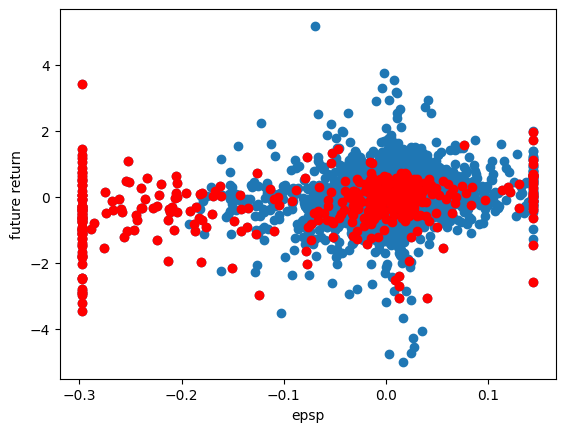

In [112]:
X_Index = 3

plt.scatter(X_Mat[:,X_Index], Y_Mat)
plt.scatter(X_Mat[row_leverage,X_Index], Y_Mat[row_leverage], c='r')
plt.xlabel('epsp')
plt.ylabel('future return')
plt.show()

**IDENTIFY OUTLIERS (UNUSUAL Y VALUE)**  
E = Y - Y_H  
R= E / S(E) = E / SQR( MSE(1 - H) )  

**R > 3 WILL BE OUTLIER**

MEAN_H = (1/N) x H'.ONE

In [144]:
Y_H_Mat = X_C_Mat.dot(B_Mat)
Y_H_Mat

array([-0.00188818,  0.02978115, -0.04248028, ..., -0.2747532 ,
       -0.88368424, -0.39703753])

In [ ]:
E = Y_Mat - Y_H_Mat
E

In [114]:
H_Sig_Mat = H_Mat * np.eye(H_Mat.shape[0])
H_Sig_Mat = H_Sig_Mat.dot(np.ones((H_Mat.shape[0], 1)))
H_Sig_Mat

array([[0.00112381],
       [0.00057693],
       [0.00111979],
       ...,
       [0.00173432],
       [0.00739518],
       [0.00192636]])

In [118]:
One_Minus_H_Sig_Mat = np.ones(H_Sig_Mat.shape) - H_Sig_Mat
One_Minus_H_Sig_Mat

array([[0.99887619],
       [0.99942307],
       [0.99888021],
       ...,
       [0.99826568],
       [0.99260482],
       [0.99807364]])

In [143]:
One_Minus_H_Sig_Mat.std()

0.0013141875958931494

In [123]:
Mean_One_Minus_H_Sig_Mat = (One_Minus_H_Sig_Mat.transpose()).dot(np.ones(One_Minus_H_Sig_Mat.shape)) / (One_Minus_H_Sig_Mat.shape[0])
Mean_One_Minus_H_Sig_Mat = Mean_One_Minus_H_Sig_Mat[0][0]
Mean_One_Minus_H_Sig_Mat

0.999047100462837

In [127]:
E_One_Minus_H_Sig_Mat = One_Minus_H_Sig_Mat - (np.ones(One_Minus_H_Sig_Mat.shape) * Mean_One_Minus_H_Sig_Mat)
SE_One_Minus_H_Sig_Mat = E_One_Minus_H_Sig_Mat * E_One_Minus_H_Sig_Mat
MSE_One_Minus_H_Sig_Mat = (SE_One_Minus_H_Sig_Mat.transpose()).dot(np.ones(SE_One_Minus_H_Sig_Mat.shape)) / SE_One_Minus_H_Sig_Mat.shape[0]
MSE_One_Minus_H_Sig_Mat = MSE_One_Minus_H_Sig_Mat[0][0]
MSE_One_Minus_H_Sig_Mat

1.7270890371994152e-06

In [141]:
SE_One_Minus_H_Sig_Mat = math.sqrt(MSE_One_Minus_H_Sig_Mat)
SE_One_Minus_H_Sig_Mat

0.0013141875958931491

In [142]:
R = One_Minus_H_Sig_Mat / SE_One_Minus_H_Sig_Mat

In [140]:
One_Minus_H_Sig_Mat

array([[0.99887619],
       [0.99942307],
       [0.99888021],
       ...,
       [0.99826568],
       [0.99260482],
       [0.99807364]])

In [136]:
index_outlier,_ = np.where(abs(R) > 3)

In [137]:
index_outlier

array([   0,    1,    2, ..., 7343, 7344, 7345])

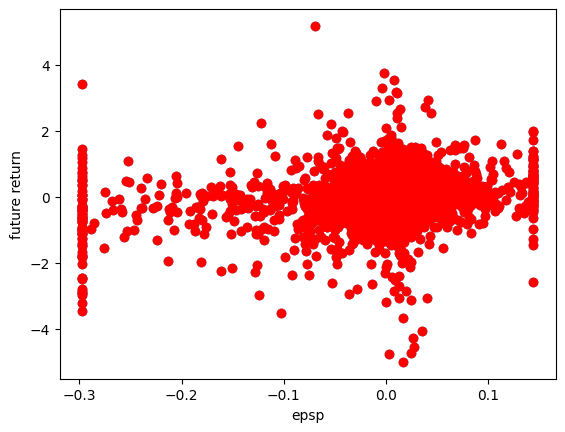

In [138]:
X_Index = 3

plt.scatter(X_Mat[:,X_Index], Y_Mat)
plt.scatter(X_Mat[index_outlier,X_Index], Y_Mat[index_outlier], c='r')
plt.xlabel('epsp')
plt.ylabel('future return')
plt.show()